# Demodulating FM Broadcast with SynQ Implemented FM Demodulator

## Receiver and Setup

- Red Pitaya SDR-Lab w/ FM antenna directly connected to ADC channel 1.
- No antiliasing filters nor front-end amplifiers.
- Front-end bandwidth (ADC S/H BW) ~ 500MHz
- Sampling Rate 122.88MHz.
- FM Broadcast are in the 2nd Niquist Zone.
- Data are captured by Xilinx ila.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal.windows import hann

## The spectrum of the ADC sampled signal

As illustrated, the strongest signal is around 26.68MHz, which corresponds to the FM broadcast channel SR-P2 (24/7 music) at Stockholm (96.2MHz = 122.88MHz - 26.68MHz).

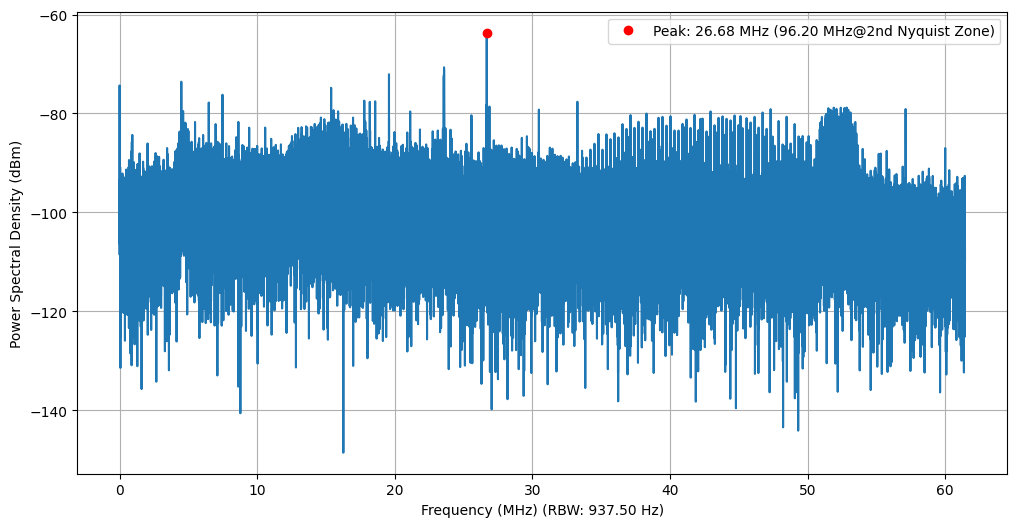

In [69]:
fs = 122.88e6
ts = 1/fs

data = np.loadtxt("received.csv", delimiter=",", skiprows=2)

data = data[:, -1] / 2**15

data = data - np.mean(data)

# calculate the spectrum of the signal, and convert to dBm (50ohm)
n = len(data)
window = hann(n)
data = data * window
fft_data = np.fft.fftshift(np.fft.fft(data)) / n
freqs = np.fft.fftshift(np.fft.fftfreq(n, ts))

# get the positive frequencies and corresponding spectrum
freqs = freqs[n//2:]
fft_data = fft_data[n//2:]

# Convert to dBm (50 ohm load)
power_spectrum = np.abs(fft_data)**2 / 50  # Power in watts
dbm_spectrum = 10 * np.log10(power_spectrum * 1e3)  # Convert to dBm

# plot half spectrum
plt.figure(figsize=(12, 6))
plt.plot(freqs / 1e6, dbm_spectrum)
# mark the maximum point
max_idx = np.argmax(dbm_spectrum)
plt.plot(freqs[max_idx] / 1e6, dbm_spectrum[max_idx], 'ro', label="Peak: {:.2f} MHz ({:.2f} MHz@2nd Nyquist Zone)".format(freqs[max_idx]/1e6, (122.88e6 - freqs[max_idx])/1e6))
plt.legend()
plt.xlabel("Frequency (MHz) (RBW: {:.2f} Hz)".format(fs/n))
plt.ylabel("Power Spectral Density (dBm)")
plt.grid(True)
plt.show()

## High-resolution spectrum around 26.68MHz

The FM demodulator involves an quadrature digital down-converter (DDC) with 128x decimation and +-75kHz baseband low-pass filtering. 
By tunning the local oscillator around 26.68MHz, we can obtain a high-resolution spectrum of the signal around 26.68MHz. 
The spectrum illustruted below are the concatenation of three spectra (+-140kHz each) with the local oscillator tuned to 26.54MHz, 26.68MHz, and 26.82MHz.
The spectrum in the range of +-75kHz around 26.68MHz has a FM like shape, which is consistent with the fact that the signal is an FM broadcast signal.

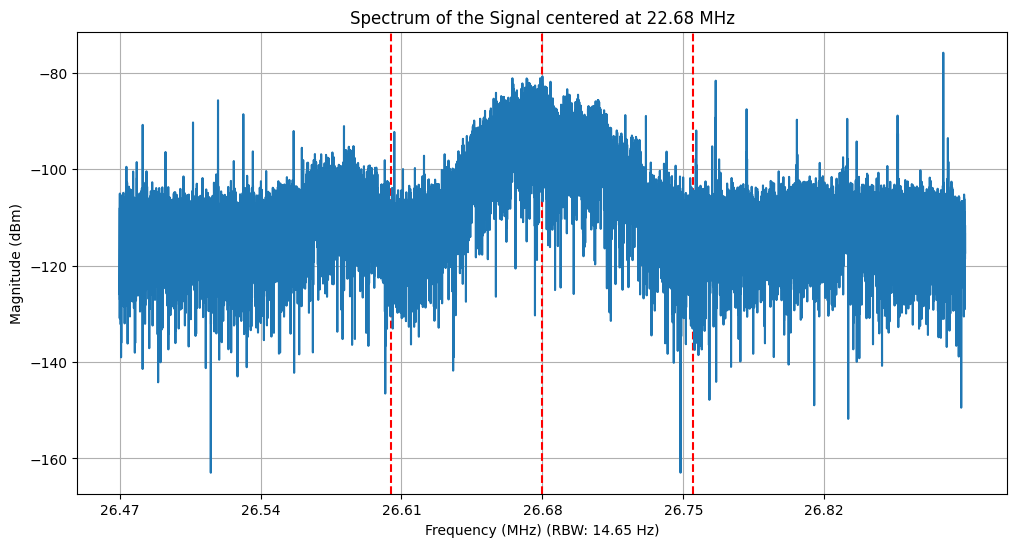

In [71]:
fs = 960e3 # Sampling frequency
ts = 1/fs   # Sampling period

def get_140k_spectrum(data_file: str, fs: float):
    data = np.loadtxt(data_file, delimiter=",", skiprows=2)

    i_data = data[:, -2] / 2**29
    q_data = data[:, -1] / 2**29

    i_data = i_data - np.mean(i_data)
    q_data = q_data - np.mean(q_data)

    complex_data = i_data + 1j * q_data
    

    # calculate the spectrum of the signal, and convert to dBm (50ohm)
    n = len(complex_data)
    window = hann(n)
    complex_data = complex_data * window
    fft_data = np.fft.fftshift(np.fft.fft(complex_data)) / n
    freqs = np.fft.fftshift(np.fft.fftfreq(n, 1/fs))

    # Convert to dBm (50 ohm load)
    power_spectrum = np.abs(fft_data) ** 2 / 50  # Power in watts
    dbm_spectrum = 10 * np.log10(power_spectrum * 1e3)  # Convert to dBm

    sels = (freqs >= -70e3) & (freqs <= 70e3)

    freqs = freqs[sels]
    dbm_spectrum = dbm_spectrum[sels]

    return freqs, dbm_spectrum, n

freqs1, spectrum_dbm1, n = get_140k_spectrum("baseband_96_34.csv", fs)
freqs2, spectrum_dbm2, n = get_140k_spectrum("baseband_96_2.csv", fs)
freqs3, spectrum_dbm3, n = get_140k_spectrum("baseband_96_06.csv", fs)

freqs = np.concatenate([freqs1-140e3, freqs2, freqs3+140e3]) + (122.88e6 - 96.2e6)
spectrum_dbm = np.concatenate([spectrum_dbm1, spectrum_dbm2, spectrum_dbm3])

plt.figure(figsize=(12, 6))
# mark 22.68MHZ +- 75kHz as the chiannel
plt.axvline(x=((122.88e6 - 96.2e6))/1e6, color='r', linestyle='--', label="22.68 MHz")
plt.axvline(x=(75e3 + (122.88e6 - 96.2e6))/1e6, color='r', linestyle='--')
plt.axvline(x=(-75e3 + (122.88e6 - 96.2e6))/1e6, color='r', linestyle='--')
plt.plot(freqs / 1e6, spectrum_dbm)
plt.xlabel("Frequency (MHz) (RBW: {:.2f} Hz)".format(fs/n))
plt.ylabel("Magnitude (dBm)")
plt.xticks(np.arange(-210e3 + (122.88e6 - 96.2e6), 210e3 + (122.88e6 - 96.2e6), 70e3)/1e6)
plt.title("Spectrum of the Signal centered at 22.68 MHz")
plt.grid()

## The FM demodulated signal

Below is the spectrum of the FM demodulated signal. The spectrum matches the spectrum of a typical FM broadcast signal with stereo multiplexing:
- 0-15kHz: L + R (mono audio signal)
- 19kHz: pilot tone
- 23-53kHz (38 kHz subcarrier): L - R (stereo difference signal)
- 57kHz: RDS (Radio Data System) signal

Also, rich harmonics can be observed in themono audio signal, which matches the fact that SR-P2 is a music channel.

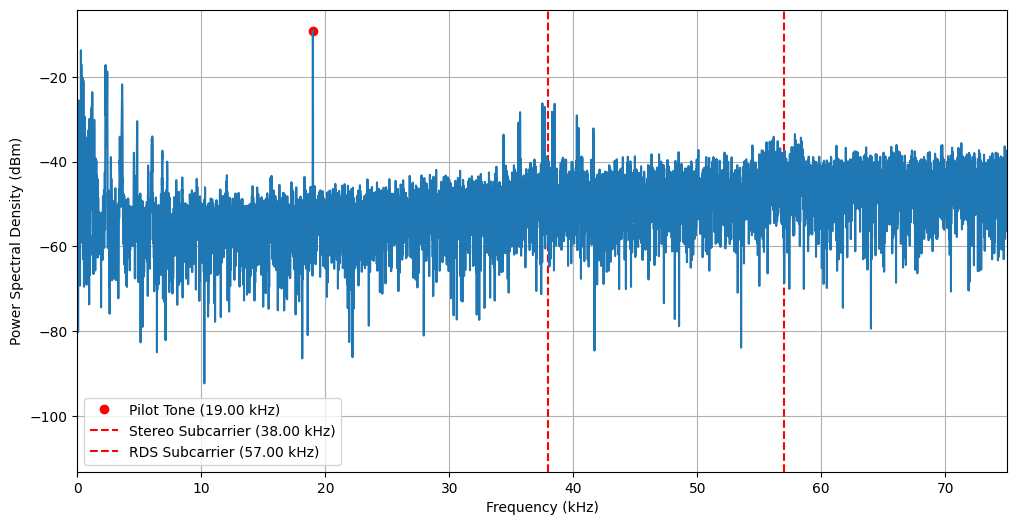

In [75]:
fs = 960e3
ts = 1/fs

data = np.loadtxt("demodulated_96_2.csv", delimiter=",", skiprows=2)

data = data[:, -1] / 2**29



# calculate the spectrum of the signal, and convert to dBm (50ohm)
n = len(data)
window = hann(n)
data_ = data * window
fft_data = np.fft.fftshift(np.fft.fft(data_)) / n
freqs = np.fft.fftshift(np.fft.fftfreq(n, ts))

# get the positive frequencies and corresponding spectrum
freqs = freqs[n//2:]
fft_data = fft_data[n//2:]

# Convert to dBm (1 ohm load)
power_spectrum = np.abs(fft_data)**2 / 1  # Power in watts
dbm_spectrum = 10 * np.log10(power_spectrum * 1e3)  # Convert to dBm

# plot half spectrum
plt.figure(figsize=(12, 6))
# mark the maximum point
max_idx = np.argmax(dbm_spectrum[1:]) + 1  # skip the DC component
plt.plot(freqs[max_idx] / 1e3, dbm_spectrum[max_idx], 'ro', label='Pilot Tone ({:.2f} kHz)'.format(freqs[max_idx]/1e3))
plt.axvline(38, color='r', linestyle='--', label='Stereo Subcarrier (38.00 kHz)')
plt.axvline(57, color='r', linestyle='--', label='RDS Subcarrier (57.00 kHz)')
plt.plot(freqs / 1e3, dbm_spectrum)
plt.xlim(0, 75)
# plt.xlim(0, 100e3)
plt.xlabel("Frequency (kHz)")
plt.ylabel("Power Spectral Density (dBm)")
plt.grid(True)
plt.legend()
